## Daisy's Test/Train Code


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
# Set path to local data directory
folder_path = ""

# Define file paths
feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")

# Load parquet files (first 30 mins = feature, last 30 mins = target side of the hour)
feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')

# Concatenating both DataFrames vertically (stacking feature + target rows)
# Note: This doesn't align features and targets — it's just combining both halves of the hour
combined_df = pd.concat([feature_df, target_df], axis=0)

# Sort to organize by stock, time, and within-hour time buckets
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)


In [3]:
# Apply feature engineering function to the combined DataFrame (includes both first + last 30 min)
def compute_orderbook_features(df):
    """
    Compute engineered order book features from raw order book snapshots.
    """
    df = df.copy()

    # Mid price and Weighted Average Price
    df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
    df['wap'] = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (
        df['bid_size1'] + df['ask_size1']
    )

    # Spread and relative spread
    df['bid_ask_spread'] = df['ask_price1'] - df['bid_price1']
    df['spread_pct'] = df['bid_ask_spread'] / df['mid_price']

    # Spread variation over time within the same time_id
    df['spread_variation'] = df.groupby(['stock_id', 'time_id'])['spread_pct'].transform(
        lambda x: x.rolling(window=10, min_periods=1).std()
    )

    # Order book imbalance and depth ratio
    df['imbalance'] = (df['bid_size1'] - df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    df['depth_ratio'] = df['bid_size1'] / df['ask_size1'].replace(0, np.nan)

    # Return only the engineered features
    keep_cols = [
        'stock_id', 'time_id', 'seconds_in_bucket',
        'wap', 'spread_pct', 'imbalance', 'depth_ratio', 'spread_variation', 'bid_ask_spread'
    ]
    return df[keep_cols]

# Apply feature engineering to the combined order book data
feature_engineered_df = compute_orderbook_features(combined_df)

# Preview result
feature_engineered_df.head()

,stock_id,time_id,seconds_in_bucket,wap,spread_pct,imbalance,depth_ratio,spread_variation,bid_ask_spread
0,8382,6,1800.0,740.160000,0.000351,0.000000,1.000000,NaN,0.26
1,8382,6,1800.0,740.160000,0.000351,0.000000,1.000000,0.000000,0.26
2,8382,6,1801.0,740.280769,0.000324,0.923077,25.000000,0.000016,0.24
3,8382,6,1801.0,740.280769,0.000324,0.923077,25.000000,0.000016,0.24
4,8382,6,1802.0,740.290769,0.000405,0.538462,3.333333,0.000033,0.30


In [4]:
time_ref_path = os.path.join(folder_path, "time_id_reference.csv")
time_ref_df = pd.read_csv(time_ref_path)
time_ref_df.head()

,date,time,time_id
0,2021-01-05,11:00:00,12
1,2021-01-05,12:00:00,13
2,2021-01-05,13:00:00,14
3,2021-01-05,14:00:00,15
4,2021-01-05,15:00:00,16


In [5]:
time_ref_df["datetime"] = pd.to_datetime(time_ref_df["date"] + " " + time_ref_df["time"])
time_ref_df.head()

,date,time,time_id,datetime
0,2021-01-05,11:00:00,12,2021-01-05 11:00:00
1,2021-01-05,12:00:00,13,2021-01-05 12:00:00
2,2021-01-05,13:00:00,14,2021-01-05 13:00:00
3,2021-01-05,14:00:00,15,2021-01-05 14:00:00
4,2021-01-05,15:00:00,16,2021-01-05 15:00:00


In [6]:
# Re-do the merge and keep only the new datetime column
feature_engineered_df = pd.merge(
    feature_engineered_df.drop(columns=["datetime"], errors="ignore"),  # just in case it already exists
    time_ref_df[["time_id", "datetime"]],
    on="time_id",
    how="left"
)
feature_engineered_df.head()
feature_engineered_df.tail()

,stock_id,time_id,seconds_in_bucket,wap,spread_pct,imbalance,depth_ratio,spread_variation,bid_ask_spread,datetime
35557446,104919,1199,3595.0,362.731439,0.000028,-0.712230,0.168067,0.000012,0.01,2021-10-07 16:00:00
35557447,104919,1199,3596.0,362.696000,0.000055,0.600000,4.000000,0.000012,0.02,2021-10-07 16:00:00
35557448,104919,1199,3597.0,362.691818,0.000028,-0.636364,0.222222,0.000012,0.01,2021-10-07 16:00:00
35557449,104919,1199,3598.0,362.721667,0.000028,-0.666667,0.200000,0.000012,0.01,2021-10-07 16:00:00
35557450,104919,1199,3599.0,362.804000,0.000028,-0.200000,0.666667,0.000012,0.01,2021-10-07 16:00:00


In [7]:
# Sort just in case
feature_engineered_df = feature_engineered_df.sort_values(by="time_id")

# Unique time_ids
unique_ids = sorted(feature_engineered_df["time_id"].unique())
cutoff = int(len(unique_ids) * 0.8)

# Train on earliest 80%, test on latest 20%
train_ids = unique_ids[:cutoff]
test_ids = unique_ids[cutoff:]

train_df_timeid = feature_engineered_df[feature_engineered_df["time_id"].isin(train_ids)]
test_df_timeid = feature_engineered_df[feature_engineered_df["time_id"].isin(test_ids)]

print("TimeID Split:")
print("Train shape:", train_df_timeid.shape)
print("Test shape:", test_df_timeid.shape)

TimeID Split:
Train shape: (28513833, 10)
Test shape: (7043618, 10)


In [8]:
qqq_df = feature_engineered_df[feature_engineered_df["stock_id"] == 104919].copy()
qqq_df["date_only"] = qqq_df["datetime"].dt.date

qqq_df.head()

,stock_id,time_id,seconds_in_bucket,wap,spread_pct,imbalance,depth_ratio,spread_variation,bid_ask_spread,datetime,date_only
31393488,104919,6,2992.0,312.299875,0.000032,0.975000,79.000000,0.000017,0.01,NaT,NaT
31393489,104919,6,2993.0,312.262896,0.000064,-0.710446,0.169286,0.000017,0.02,NaT,NaT
31393490,104919,6,2993.0,312.262896,0.000064,-0.710446,0.169286,0.000017,0.02,NaT,NaT
31393491,104919,6,2994.0,312.280598,0.000064,-0.940178,0.030833,0.000017,0.02,NaT,NaT
31393492,104919,6,2994.0,312.280598,0.000064,-0.940178,0.030833,0.000017,0.02,NaT,NaT


In [9]:
#  Compute log returns (per time_id)
qqq_df["log_return"] = qqq_df.groupby("time_id")["wap"].transform(lambda x: np.log(x / x.shift(1)))

# Compute realized volatility per time_id
rv_df = qqq_df.groupby("time_id")["log_return"].agg(lambda x: np.sqrt(np.sum(x**2))).reset_index()

rv_df = rv_df.rename(columns={"log_return": "realized_volatility"})

#  Merge back into qqq_df
qqq_df = pd.merge(qqq_df, rv_df, on="time_id", how="left")

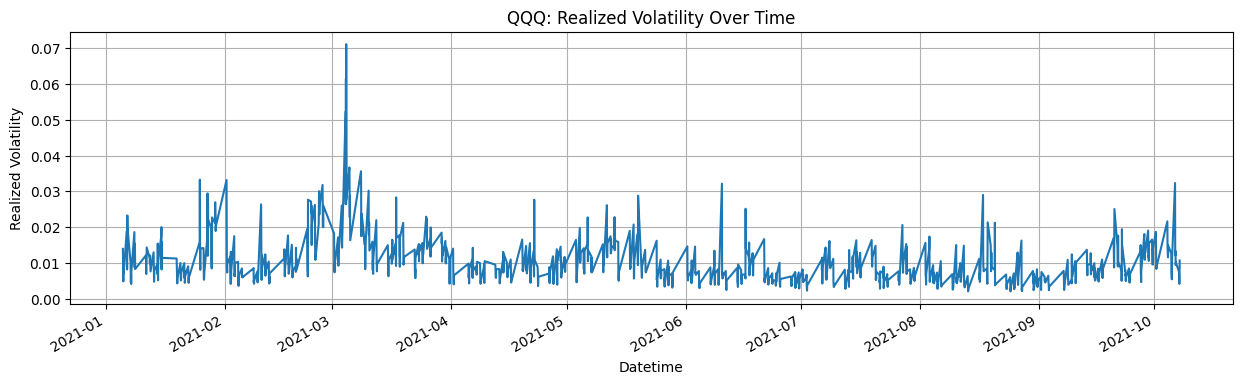

In [10]:
# Plot volatility over time
qqq_df.groupby("datetime")["realized_volatility"].mean().plot(
    figsize=(15, 4), title="QQQ: Realized Volatility Over Time"
)
plt.xlabel("Datetime")
plt.ylabel("Realized Volatility")
plt.grid(True)
plt.show()

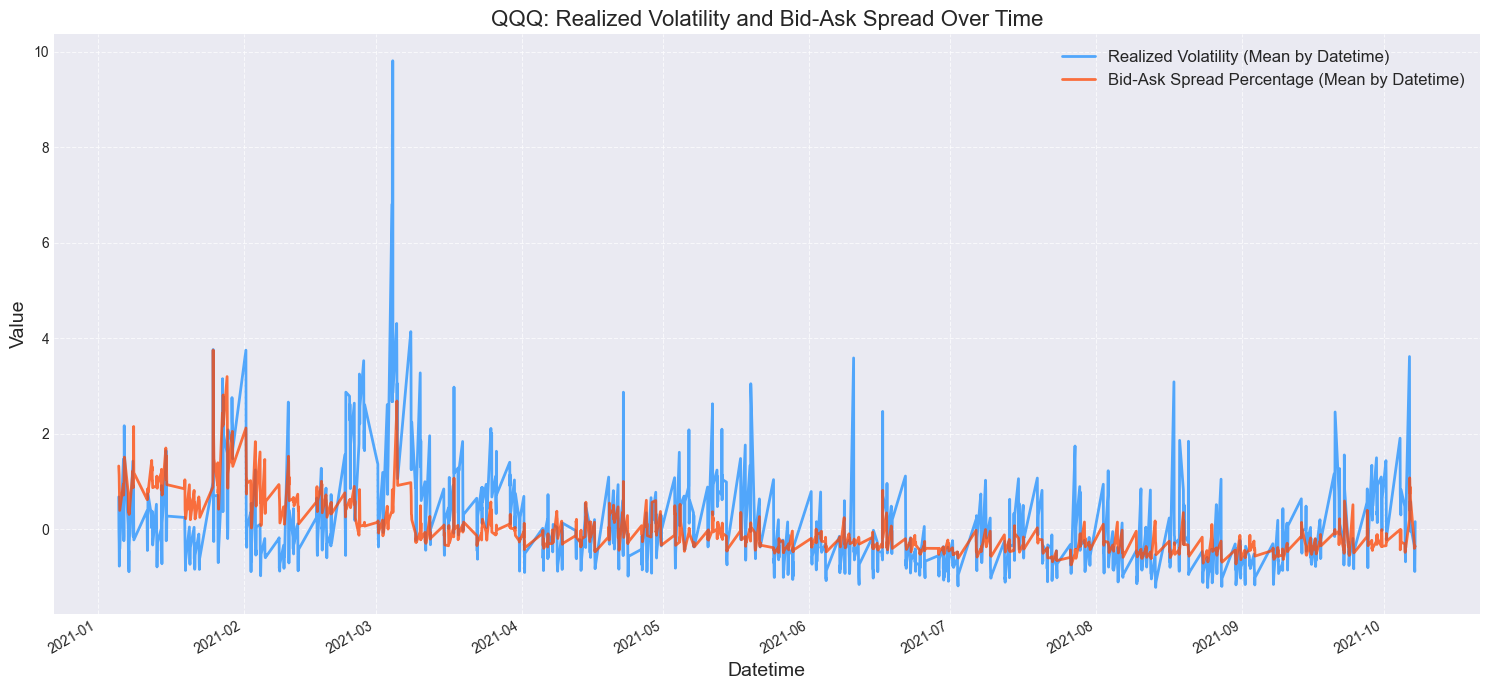

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
qqq_df[['spread_pct_scaled', 'realized_volatility_scaled']] = scaler.fit_transform(qqq_df[['spread_pct', 'realized_volatility']])


realized_vol_by_datetime = qqq_df.groupby("datetime")["realized_volatility_scaled"].mean()
bid_ask_spread_by_datetime = qqq_df.groupby("datetime")["spread_pct_scaled"].mean()

# Plotting
plt.figure(figsize=(15, 7)) # Adjusted figsize for better visibility of two lines
plt.style.use('seaborn-v0_8-darkgrid')

realized_vol_by_datetime.plot(
    label="Realized Volatility (Mean by Datetime)",
    color='dodgerblue',
    linewidth=2,
    alpha=0.75
)
bid_ask_spread_by_datetime.plot(
    label="Bid-Ask Spread Percentage (Mean by Datetime)",
    color='orangered',
    linewidth=2,
    alpha=0.75
)

plt.title("QQQ: Realized Volatility and Bid-Ask Spread Over Time", fontsize=16)
plt.xlabel("Datetime", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# XGBOOST

## Using 80/20 split on time_id for test/training data

In [12]:
xgb_df = qqq_df.copy()

In [13]:
features_to_lag = ["realized_volatility", "wap", "imbalance", "spread_variation", "spread_pct", "depth_ratio", "log_return"]

for feature in features_to_lag:
    for lag in [1, 5, 10]:
        xgb_df[f"{feature}_lag_{lag}"] = xgb_df[feature].shift(lag)

xgb_df = xgb_df.dropna().reset_index(drop=True)

In [14]:
current_features = ["wap", "spread_pct", "imbalance", "depth_ratio", "spread_variation", "log_return"]
lagged_features = [col for col in xgb_df.columns if 'lag' in col]

feature_columns = current_features + lagged_features

In [15]:
X = xgb_df[feature_columns]
y = xgb_df["realized_volatility"]

cutoff = int(len(xgb_df) * 0.8)

X_train = X.iloc[:cutoff]
y_train = y.iloc[:cutoff]
X_test = X.iloc[cutoff:]
y_test = y.iloc[cutoff:]

In [16]:
from xgboost import XGBRegressor

In [17]:
xgb_model = XGBRegressor(
    n_estimators=100, #number of decision tress
    max_depth=4, #limits how complex each tree can be - avoids overfitting
    learning_rate=0.1, #how much each tree "corrects" the model
    objective='reg:squarederror', #goal is to predict continuous number
    random_state=42 # fixes randomness for repeatability
)

In [18]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [19]:
y_pred = xgb_model.predict(X_test)

In [20]:
y_test.head()

3308505    0.002056
3308506    0.002056
3308507    0.002056
3308508    0.002056
3308509    0.002056
Name: realized_volatility, dtype: float64

### Performance Metrics

In [21]:
from sklearn.metrics import mean_squared_error

In [22]:
def qlike(y_true, y_pred):
    return np.mean(np.log(y_pred) + (y_true / y_pred))

In [23]:
mse = mean_squared_error(y_test, y_pred)
qlikel = qlike(y_test.values, y_pred)

print(f"MSE: {mse:.12f}")
print(f"QLIKE: {qlikel:.6f}")

MSE: 0.000000005195
QLIKE: -3.926504


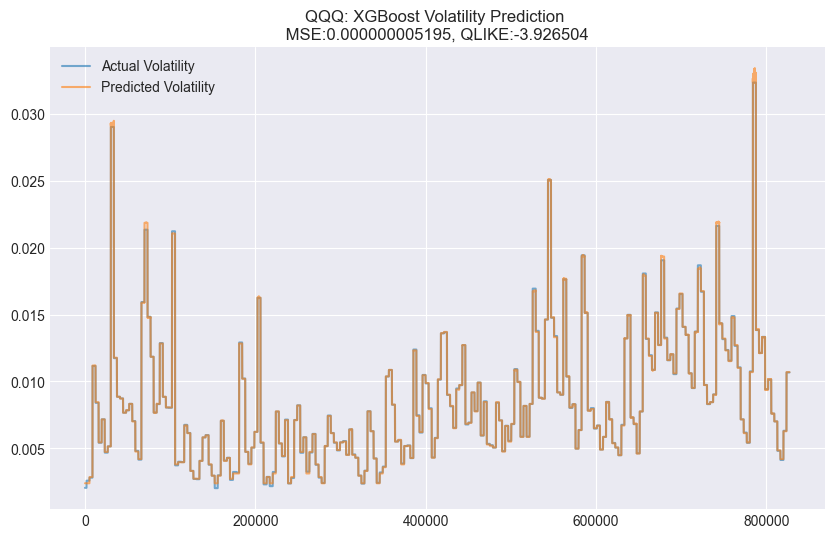

In [24]:
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual Volatility", alpha=0.6)
plt.plot(y_pred, label="Predicted Volatility", alpha=0.6)
plt.legend()
plt.title(f"QQQ: XGBoost Volatility Prediction \n MSE:{mse:.12f}, QLIKE:{qlikel:.6f} ")
plt.show()

## Final Version - aggregating data for each time id. 

In [25]:
agg_df = xgb_df.groupby("time_id")["realized_volatility"].mean().reset_index()

In [26]:
X = agg_df.drop(columns=["time_id", "realized_volatility"])  # all features except time_id and target
y = agg_df["realized_volatility"]

In [27]:
agg_df = xgb_df.groupby("time_id").agg({
    "realized_volatility": "mean",
    "wap": "mean",  
    "spread_pct": "mean",
    "imbalance": "mean",
    "depth_ratio": "mean",
    "spread_variation": "mean",
    "log_return": "mean",
    "bid_ask_spread": "mean"
}).reset_index()

# Now select features and target
X = agg_df.drop(columns=["time_id", "realized_volatility"])
y = agg_df["realized_volatility"]

In [28]:
cutoff = int(len(agg_df) * 0.8)

X_train = X.iloc[:cutoff]
y_train = y.iloc[:cutoff]
X_test = X.iloc[cutoff:]
y_test = y.iloc[cutoff:]

In [29]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [30]:
y_pred = xgb_model.predict(X_test)

In [31]:
mse = mean_squared_error(y_test, y_pred)
qlikel = qlike(y_test.values, y_pred)

print(f"MSE: {mse:.12f}")
print(f"QLIKE: {qlikel:.6f}")

MSE: 0.000014424478
QLIKE: -3.822595


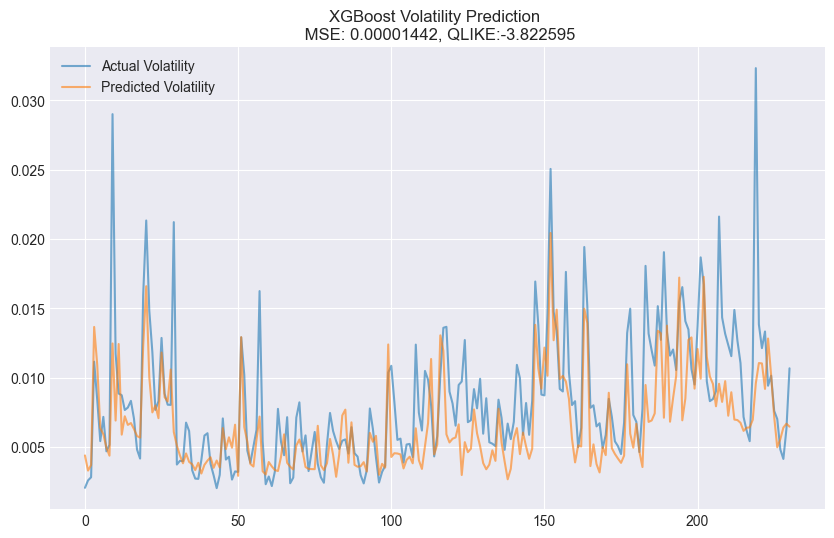

In [32]:
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual Volatility", alpha=0.6)
plt.plot(y_pred, label="Predicted Volatility", alpha=0.6)
plt.legend()
plt.title(f"XGBoost Volatility Prediction \n MSE: {mse:.8f}, QLIKE:{qlikel:.6f}")
plt.show()

# BAS Prediction

In [33]:
xgb_df

,stock_id,time_id,seconds_in_bucket,wap,spread_pct,imbalance,depth_ratio,spread_variation,bid_ask_spread,datetime,...,spread_variation_lag_10,spread_pct_lag_1,spread_pct_lag_5,spread_pct_lag_10,depth_ratio_lag_1,depth_ratio_lag_5,depth_ratio_lag_10,log_return_lag_1,log_return_lag_5,log_return_lag_10
0,104919,12,3597.0,309.886944,0.000032,0.388889,2.272727,0.000017,0.01,2021-01-05 11:00:00,...,0.000026,0.000065,0.000097,0.000032,1.388889,2.500000,2.000000,0.000011,-1.424810e-04,0.000071
1,104919,12,1205.0,310.278182,0.000064,0.818182,10.000000,0.000014,0.02,2021-01-05 11:00:00,...,0.000026,0.000032,0.000097,0.000065,2.272727,2.500000,2.638522,0.000049,0.000000e+00,0.000090
2,104919,12,1204.0,310.221306,0.000032,-0.738806,0.150215,0.000014,0.01,2021-01-05 11:00:00,...,0.000026,0.000064,0.000032,0.000065,10.000000,2.000000,2.638522,0.001262,2.437500e-04,0.000000
3,104919,12,1202.0,310.271306,0.000032,-0.738806,0.150215,0.000016,0.01,2021-01-05 11:00:00,...,0.000026,0.000032,0.000065,0.000065,0.150215,1.388889,3.353333,0.000193,1.107299e-05,0.000000
4,104919,12,1201.0,310.251228,0.000032,-0.754386,0.140000,0.000016,0.01,2021-01-05 11:00:00,...,0.000026,0.000032,0.000032,0.000097,0.150215,2.272727,2.500000,-0.000032,4.942743e-05,-0.000142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4135627,104919,1199,1969.0,364.045714,0.000055,-0.428571,0.400000,0.000014,0.02,2021-10-07 16:00:00,...,0.000013,0.000055,0.000027,0.000055,0.584167,0.153846,2.800000,-0.000059,-3.067117e-05,-0.000028
4135628,104919,1199,1970.0,364.046133,0.000055,-0.386658,0.442317,0.000014,0.02,2021-10-07 16:00:00,...,0.000013,0.000055,0.000027,0.000027,0.400000,0.154615,0.771456,-0.000059,1.585933e-08,-0.000029
4135629,104919,1199,1972.0,364.010909,0.000027,-0.818182,0.100000,0.000014,0.01,2021-10-07 16:00:00,...,0.000013,0.000055,0.000055,0.000055,0.442317,0.876250,0.666667,0.000001,-5.489784e-06,-0.000045
4135630,104919,1199,3598.0,362.721667,0.000028,-0.666667,0.200000,0.000012,0.01,2021-10-07 16:00:00,...,0.000014,0.000027,0.000027,0.000055,0.100000,8.507042,1.363636,-0.000097,5.385562e-05,-0.000018


# --- 1. Data Preparation ---
# Data sorted by 'time_id'.
# 'realized_volatility_lag1' feature created.
# Dropped rows with NaN values. Shape after drop: (4135631, 37)

# --- 2. Visual Inspection ---


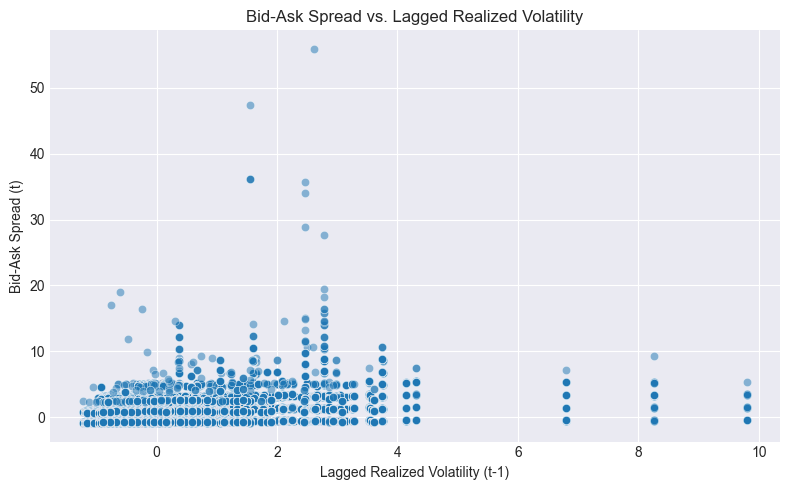

# Scatter plot generated.

# --- 3. Statistical Assessment ---
# Rainbow test statistic: 2.0715
# P-value: 0.0000
# Interpretation: The Rainbow test suggests evidence of non-linearity (p-value < 0.05).

# --- Optional: Pearson Correlation ---
# Pearson Correlation between Bid-Ask Spread Percentage and Lagged Realized Volatility:
# Correlation coefficient: 0.1944
# P-value: 0
# The correlation is statistically significant.


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.stats.diagnostic import linear_rainbow
from scipy.stats import pearsonr # Ensure this is imported at the top

# --- This section assumes 'xgb_df' is already loaded in your environment ---
# For example, if it's created in a cell like this:
# qqq_df = feature_engineered_df[feature_engineered_df["stock_id"] == 104919].copy()
# ... (realized volatility calculations for qqq_df) ...
# xgb_df = qqq_df.copy() # Or however xgb_df is derived and contains 'realized_volatility' and 'bid_ask_spread'

# --- 1. Data Preparation ---
# This section prepares the data for linearity testing.
print("# --- 1. Data Preparation ---")

scaler = StandardScaler()
xgb_df[['spread_pct_scaled', 'realized_volatility_scaled']] = scaler.fit_transform(xgb_df[['spread_pct', 'realized_volatility']])


# a. Ensure Data is Chronologically Ordered (using 'time_id' if available, otherwise assuming pre-sorted)
if 'time_id' in xgb_df.columns:
    xgb_df = xgb_df.sort_values(by='time_id').reset_index(drop=True)
    print("# Data sorted by 'time_id'.")
else:
    print("# 'time_id' not found, assuming data is already chronologically ordered.")

# b. Create Lagged Volatility Feature
xgb_df['realized_volatility_lag1'] = xgb_df['realized_volatility_scaled'].shift(1)
print("# 'realized_volatility_lag1' feature created.")

# c. Drop Missing Values (from lagging and any pre-existing NaNs in the relevant columns)
xgb_df_analysis = xgb_df.dropna(subset=['realized_volatility_lag1', 'spread_pct_scaled']).copy()
print(f"# Dropped rows with NaN values. Shape after drop: {xgb_df_analysis.shape}")

if xgb_df_analysis.empty:
    print("# DataFrame is empty after dropping NaN values. Cannot proceed with analysis.")
else:
    # --- 2. Visual Inspection ---
    print("\n# --- 2. Visual Inspection ---")

    # a. Scatter Plot
    # This plot helps visually assess the relationship between bid-ask spread and lagged volatility.
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x='realized_volatility_lag1', y='spread_pct_scaled', data=xgb_df_analysis, alpha=0.5) # Added alpha for better viz if points overlap
    plt.title('Bid-Ask Spread vs. Lagged Realized Volatility')
    plt.xlabel('Lagged Realized Volatility (t-1)')
    plt.ylabel('Bid-Ask Spread (t)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print("# Scatter plot generated.")

    # --- 3. Statistical Assessment ---
    print("\n# --- 3. Statistical Assessment ---")

    # a. Rainbow Test for Linearity
    # This test statistically checks if the linear model fits well across the range of predicted values.
    X_stat = xgb_df_analysis[['realized_volatility_lag1']]
    y_stat = xgb_df_analysis['spread_pct_scaled']

    # Add constant term for statsmodels OLS
    X_with_const_stat = sm.add_constant(X_stat)
    
    # Fit OLS model
    try:
        ols_model_stat = sm.OLS(y_stat, X_with_const_stat).fit()
        # Perform Rainbow test
        rainbow_statistic, p_value = linear_rainbow(ols_model_stat)
        print(f"# Rainbow test statistic: {rainbow_statistic:.4f}")
        print(f"# P-value: {p_value:.4f}")

        if p_value < 0.05:
            print("# Interpretation: The Rainbow test suggests evidence of non-linearity (p-value < 0.05).")
        else:
            print("# Interpretation: The Rainbow test shows no evidence against linearity (p-value >= 0.05).")
    except Exception as e:
        print(f"# OLS model fitting or Rainbow test could not be performed: {e}")
        print("# This can happen with insufficient data, perfect multicollinearity, or other data issues.")

    # --- Pearson Correlation (Optional, but often useful) ---
    # This measures the linear correlation between current bid-ask spread and lagged volatility.
    print("\n# --- Optional: Pearson Correlation ---")
    
    # Using scipy.stats for p-value of correlation
    try:
        corr_coef_scipy, p_val_scipy = pearsonr(xgb_df_analysis['realized_volatility_lag1'], xgb_df_analysis['bid_ask_spread'])
        print(f"# Pearson Correlation between Bid-Ask Spread Percentage and Lagged Realized Volatility:")
        print(f"# Correlation coefficient: {corr_coef_scipy:.4f}")
        print(f"# P-value: {p_val_scipy:.4g}") # Using .4g for scientific notation if p-value is very small
        if p_val_scipy < 0.05:
            print("# The correlation is statistically significant.")
        else:
            print("# The correlation is not statistically significant.")
    except Exception as e:
        print(f"# Pearson correlation could not be computed: {e}")


In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# sorts data by time and creates a lead volatility feature.
print("# --- Data Preparation ---")
xgb_df = xgb_df.sort_values(by='time_id').reset_index(drop=True)
xgb_df['realized_volatility_lead1'] = xgb_df['realized_volatility'].shift(-1) # Future volatility
xgb_df = xgb_df.dropna(subset=['realized_volatility_lead1', 'bid_ask_spread'])
print(f"xgb_df shape after preparation: {xgb_df.shape}")

# groups data by 'time_id' and calculates mean values for features and the target.
print("\n# --- Aggregation by time_id ---")
agg_df = xgb_df.groupby('time_id').agg({
    'realized_volatility_lead1': 'mean',
    'spread_pct': 'mean',
    'wap': 'mean',
    'imbalance': 'mean',
    'depth_ratio': 'mean',
    'spread_variation': 'mean',
    'log_return': 'mean',
    'bid_ask_spread': 'mean'  # Target variable
}).reset_index()
print(f"agg_df shape after aggregation: {agg_df.shape}")

# standardizes features to have zero mean and unit variance.
print("\n# --- Feature Scaling ---")
feature_cols = ['realized_volatility_lead1', 'spread_pct', 'wap', 'imbalance',
                'depth_ratio', 'spread_variation', 'log_return']
X = agg_df[feature_cols]
y = agg_df['bid_ask_spread']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"X_scaled shape: {X_scaled.shape}")

# splits data 80/20
print("\n# --- Train-Test Split ---")
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)
print(f"Training set shapes: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Test set shapes: X_test: {X_test.shape}, y_test: {y_test.shape}")

# trains an XGBoost Regressor model to predict bid-ask spread.
print("\n# --- Model Training (XGBoost) ---")
model = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42, objective='reg:squarederror')
model.fit(X_train, y_train)
print("XGBoost model trained.")

# MSE, MAE, RMSE, and R-squared.
print("\n# --- Model Evaluation ---")
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"R-squared (R²): {r2:.4f}")

# compare actual vs. predicted bid-ask spread for the test set.
print("\n# --- Comparison of Actual vs. Predicted Bid-Ask Spread (Test Set) ---")
test_indices = y_test.index # Get original indices from agg_df for the test set
test_time_ids = agg_df.loc[test_indices, 'time_id']

comparison_df = pd.DataFrame({
    'time_id': test_time_ids.values,
    'actual_bid_ask_spread': y_test.values,
    'predicted_bid_ask_spread': y_pred
})
print("Comparison DataFrame (first 5 rows):")
print(comparison_df.head())
print(f"\nComparison DataFrame shape: {comparison_df.shape}")



# --- Data Preparation ---
xgb_df shape after preparation: (4135631, 38)

# --- Aggregation by time_id ---
agg_df shape after aggregation: (1152, 9)

# --- Feature Scaling ---
X_scaled shape: (1152, 7)

# --- Train-Test Split ---
Training set shapes: X_train: (921, 7), y_train: (921,)
Test set shapes: X_test: (231, 7), y_test: (231,)

# --- Model Training (XGBoost) ---
XGBoost model trained.

# --- Model Evaluation ---
Mean Squared Error (MSE): 0.000000
Mean Absolute Error (MAE): 0.000295
Root Mean Squared Error (RMSE): 0.000452
R-squared (R²): 0.9263

# --- Comparison of Actual vs. Predicted Bid-Ask Spread (Test Set) ---
Comparison DataFrame (first 5 rows):
   time_id  actual_bid_ask_spread  predicted_bid_ask_spread
0      963               0.013159                  0.012568
1      964               0.012671                  0.012182
2      965               0.011619                  0.011349
3      966               0.013279                  0.013328
4      967               0.012552

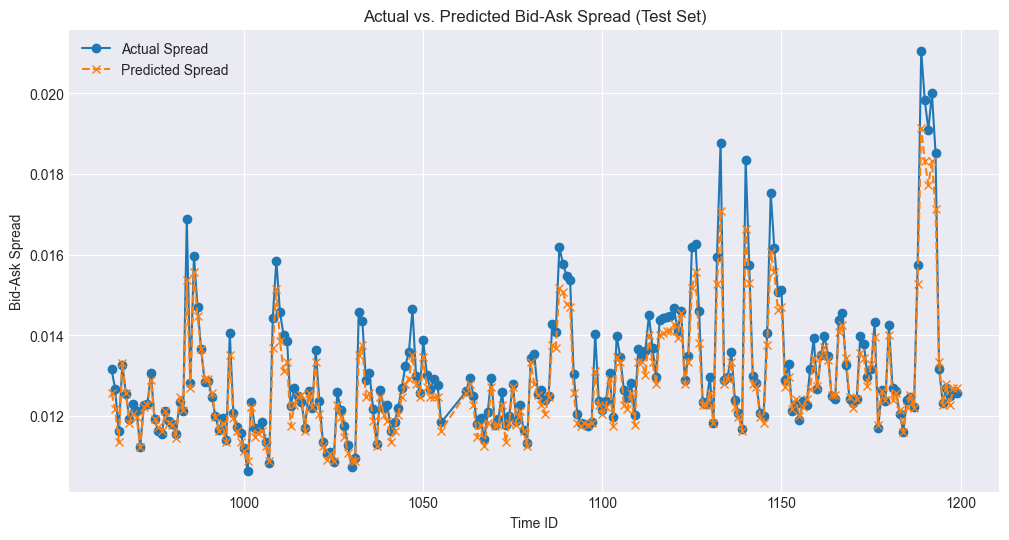

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['time_id'], comparison_df['actual_bid_ask_spread'], label='Actual Spread', marker='o', linestyle='-')
plt.plot(comparison_df['time_id'], comparison_df['predicted_bid_ask_spread'], label='Predicted Spread', marker='x', linestyle='--')
plt.xlabel('Time ID')
plt.ylabel('Bid-Ask Spread')
plt.title('Actual vs. Predicted Bid-Ask Spread (Test Set)')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
comparison_df.head()

,time_id,actual_bid_ask_spread,predicted_bid_ask_spread
0,963,0.013159,0.012568
1,964,0.012671,0.012182
2,965,0.011619,0.011349
3,966,0.013279,0.013328
4,967,0.012552,0.012568
